**CV2021 - week 6**

**CONTENTS**

* [K-Means image segmentation](https://colab.research.google.com/drive/1Ldlj1RJNYfpvvSDcheUFRqkeuQc5k0Xm#scrollTo=3uRz47jY9XWd&line=14&uniqifier=1)

* [Otsu method for thresholding](https://colab.research.google.com/drive/1Ldlj1RJNYfpvvSDcheUFRqkeuQc5k0Xm#scrollTo=wuu4iRXDNVNQ&line=21&uniqifier=1)

* [GrabCut](https://colab.research.google.com/drive/1Ldlj1RJNYfpvvSDcheUFRqkeuQc5k0Xm#scrollTo=DJq8gqkPywIC&line=8&uniqifier=1)

* [Hough Transform](https://colab.research.google.com/drive/1Ldlj1RJNYfpvvSDcheUFRqkeuQc5k0Xm#scrollTo=G-KbZuL9UPao&line=19&uniqifier=1)

* [Stereo vision matching](https://colab.research.google.com/drive/1Ldlj1RJNYfpvvSDcheUFRqkeuQc5k0Xm#scrollTo=i7tm_j-NME6-&line=33&uniqifier=1)

**HOMEWORK**

* **4x0.25bp** 

  a) Extend the Hough transform demo and plot all the possible lines above a given threshold (relative to the maximum value).

  b) Increase the size of the Hough space response for the given demo (*Intel8086* photo). What happens to the most probable line?

  c) Using an image segemntation technique, determine the best possible initialization for GrabCut, by selecting the smallest possible rectangle enclosing the foreground object. 
  
  d) Using the channel-wise image histogram, write a procedure for a better initialization of K-Means.

*  **1bp** Using the Hough Transform, implement a simple demo for lane detection. Analyze the Hough response in a curve. How would you fit a curve to a set of extracted keypoints?

* **2bp** Using Graph Cut documentation, propose your own implementation (using only numpy and python data structures), using one of the described Graph Cut methods. Write a *colab* demo, explaining your implementation. For a         graph cut algorithm, you can use packages similar to *MaxFlow*.



**1. K-Means image segmentation**

This was the third task from *week 5* homework. This solution provides an implementation for the *K-Means* algorithm as an iterative procedure divided into two phases. 

In the first phase, the image pixels are assigned to the cluster represented by the closest centroid. The distance metric used was the *L2-norm* in the *Lab* image representation space.

The second phase is the so called *update step*, where the means for the clusters are updated as the means of the pixels included in that cluster.

This sequence of those two steps is repeated for a fixed number of iterations. The algorithm is guaranteed to converge, but the convergence speed depends on the quality of the input data.

**References**

* [K-Means algorithm](https://scikit-learn.org/stable/modules/clustering.html#k-means)
* [K-Means convergence](https://proceedings.neurips.cc/paper/1994/file/a1140a3d0df1c81e24ae954d935e8926-Paper.pdf)


In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


def visualize_segmentation_map(map):
 
  h, w = map.shape
  max_colors = int(map.max())
  colors = [np.random.randint(0, 255, size=(3,)).astype(np.uint8) for _ in range(max_colors)]
  output_image = np.zeros((h, w, 3), dtype=np.uint8)
  
  for i in range(int(h)):
    for j in range(int(w)):
      output_image[i, j, :] = colors[int(map[i, j]) - 1]

  plt.imshow(output_image)


def generate_mu(X, K):
  N, d = X.shape
  mu = np.zeros((d, K)) 

  # use a min - max initialization to 
  # distribute the means across the range
  min_vec = np.zeros(d)
  max_vec = np.zeros(d)

  for i in range(d):
    min_vec[i] = np.min(X[:, i])
    max_vec[i] = np.max(X[:, i])

  for k in range(K):
    mu[:, k] = min_vec.T  + (k - 1) / K * (max_vec - min_vec).T
  
  return mu


# img is the Lab image
# K is the number of segments
def KMeans_segmentation(img, K, niter=10):
  h, w, d = img.shape
  pixels = np.zeros((h * w, d))
  k = 0
  for i in range(h):
    for j in range(w):
      pixels[k, :] = img[i, j, :].astype(np.float32)
      k += 1
  
  map = np.zeros((h, w), dtype=np.uint8)
  means = generate_mu(pixels, K)
  
  # phase 1 - assign each pixel to the closest mean
  # phase 2- update the mean of each cluster
  N = pixels.shape[0]

  it = 0
  while it < niter:
    it += 1
    # phase 1
    for i in range(N):
      diff = means - np.repeat(np.array([pixels[i, :]]).T, K, axis=1)
      dist = np.linalg.norm(diff, axis=0)
      k = np.argmin(dist)
      map[i // w, i % w] = k
    
    # phase 2
    for k in range(K):
      cluster_idx = np.argwhere(map == k)
      
      if len(cluster_idx) > 0:
        cluster_idx = [ i * w + j for i, j in cluster_idx]
        cluster_pixels = pixels[cluster_idx]
        means[:, k] = np.mean(cluster_pixels, axis=0)
  
  return means, map

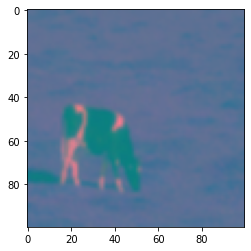

In [3]:
image_cow = cv.imread("/content/drive/MyDrive/CVCourse21/pics/cow.jpg")
image_cow = cv.resize(image_cow, (100, 100))
image_cow = cv.GaussianBlur(image_cow,(3, 3), 0)
img_lab = cv.cvtColor(image_cow, cv.COLOR_BGR2LAB)
plt.imshow(img_lab)

[[-37.2         21.4589372   77.95562436  93.15843162 170.3989899 ]
 [104.         126.97101449 113.25352597 112.8571884  125.36363636]
 [117.8        130.81320451 148.64052288 149.07618744 140.87373737]]


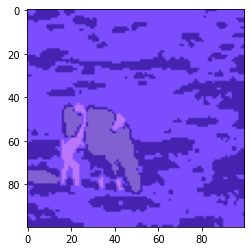

In [4]:
means, map = KMeans_segmentation(img_lab, K=5)
print(means)
visualize_segmentation_map(map)


**2. Otsu's method for tresholding**

Instead of using an arbitrary value for binary thresholding, the otsu's method aims to find a value sunch that the binarization is optimal. 

For a binarization to be optimal, both classes are to be well defined and the pixel values corresponding to each class have to be as homogeneous as possible. 

Imagine an image representing two different textures. When computing the histogram, it is going to be represented by two peaks for the intensity levels representing the textures (characterized by different colors). A good threshold would be a value in the middle between those two peaks (as in the Gaussian Mixture example from *week 4*). 

Otsu's method finds the optimal threshold, using the histogram, such that the missclassification erro is minimal. For this, the *P* values (probabilities for intensity levels) are computed using the normalized histogram. Then, the *q values* are the cumulative sums for the histogram, computed for both classes. 

Then, the means (*mu values*) for the classes are computed as weighted sums for intra-cass intensity levels, weighted by the probability of each intensity level, inside it's designed class.

Finally, using the computed means, the variance (*sigma values*) is computed, for each of the classes. In the same fashion, the variance with respect to the class mean is weighted by the intensity level probability, then normalized to the class probability. 


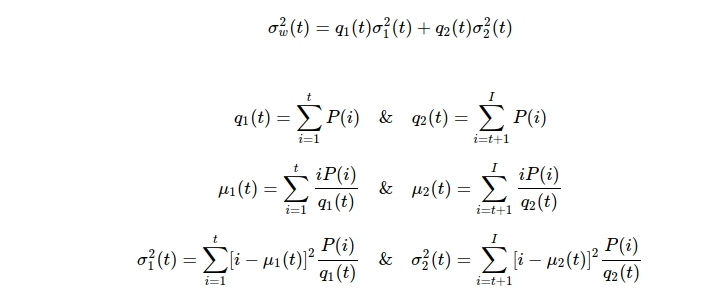


**References**

* [OpenCV description of Otsu's method](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)

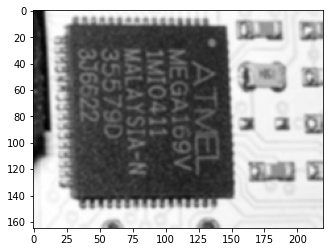

In [5]:
image_rgb = cv.imread("/content/drive/MyDrive/CVCourse21/pics/fingerprint.jpg")
image_rgb = cv.GaussianBlur(image_rgb,(5, 5), 0)
img_gray = cv.cvtColor(image_rgb, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

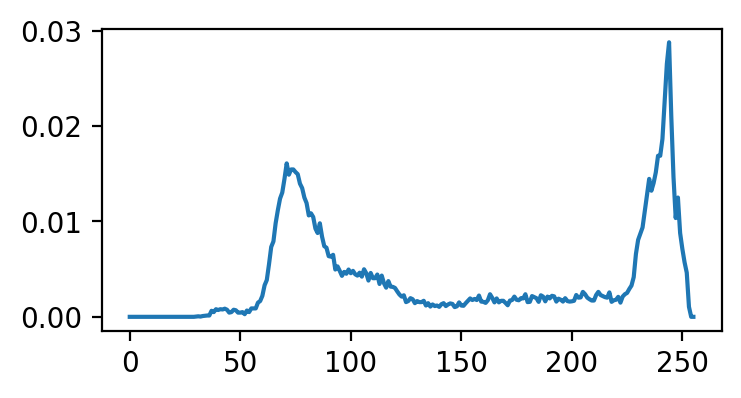

In [6]:
# now, we will compute the histogram and the cumulative sum over the histogram
histogram = cv.calcHist([img_gray], [0], None, [256], [0, 256])
histogram_normalized = histogram.ravel()/histogram.sum()
# cumulative sum
Q = histogram_normalized.cumsum()

plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['figure.dpi'] = 200
plt.plot(np.arange(256), histogram_normalized)

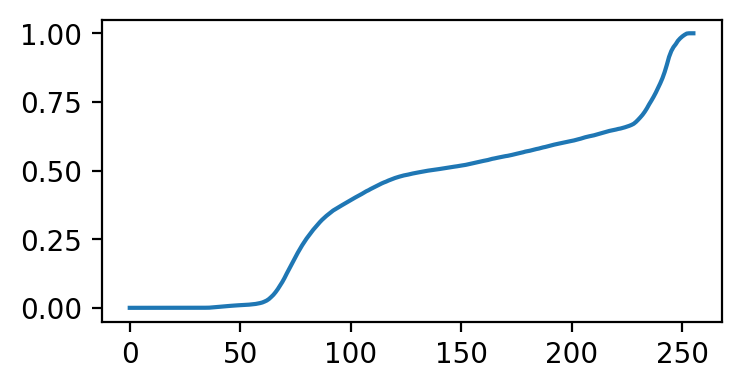

In [7]:
plt.plot(np.arange(256), Q)

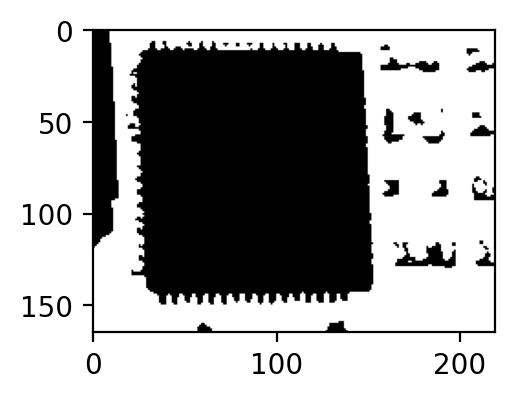

In [8]:
bins = np.arange(256)
min_variance = np.inf
threshold = -1

for i in range(1, 256):
  p1, p2 = np.split(histogram_normalized, [i]) # assume i is the threshold
  Q1 = Q[i] # class probability
  Q2 = Q[255] - Q[i]

  if Q1 > 1.e-6 and Q2 > 1.e-6: # avoid div by zero
    b1, b2 = np.hsplit(bins, [i]) # intensities corresponding to each class
    m1 = 1/Q1 * np.sum(p1 * b1) # compute class means
    m2 = 1/Q2 * np.sum(p2 * b2)

    sigma_1 = 1/ Q1 * np.sum(((b1 - m1)**2) * p1) # class variance
    sigma_2 = 1/ Q2 * np.sum(((b2 - m2)**2) * p2)

    # compute objective
    total_variance = sigma_1 * Q1 + sigma_2 * Q2

    if total_variance < min_variance:
      min_variance = total_variance
      threshold = i


_, binary_img = cv.threshold(img_gray, threshold, 255, cv.THRESH_BINARY)
plt.imshow(binary_img, cmap='gray')


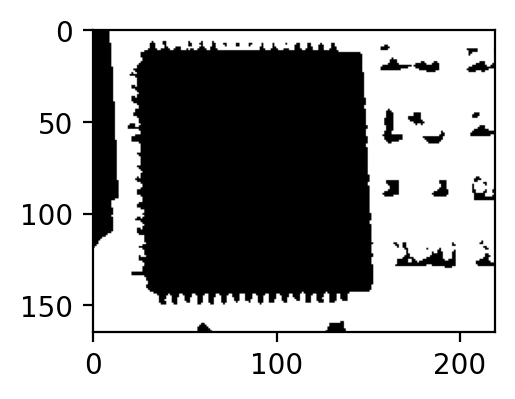

In [9]:
ret, otsu = cv.threshold(img_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(otsu, cmap='gray')


**3. GrabCut**

The *Grab Cut* method addresses the challenge of separating object from background in a colored image, given certain constraints. The user is requested to mark a single rectangle around the object, defining the outer part of the rectangle as definite background, and the inner part of it as an unknown combination of the object (foreground) and some background. As explained in the following, these constraints are used as initial solution to the problem, leading to an iterative method which in conclusion aims to assign each pixel in the image its label - Background or Foreground.

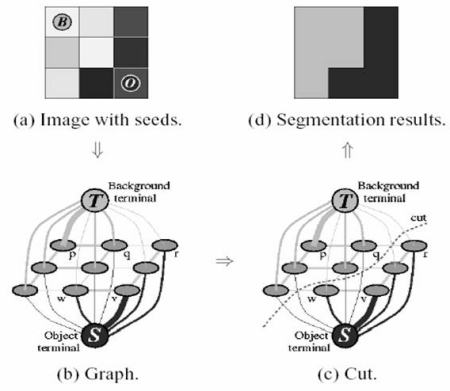

**References**
 * [OpenCV grabcut](https://docs.opencv.org/master/d8/d83/tutorial_py_grabcut.html)

 * [About GrabCut](https://sandipanweb.wordpress.com/2018/02/11/interactive-image-segmentation-with-graph-cut/)

 * [OpenCV implementation paper](https://www.csd.uwo.ca/~yboykov/Papers/pami04.pdf)


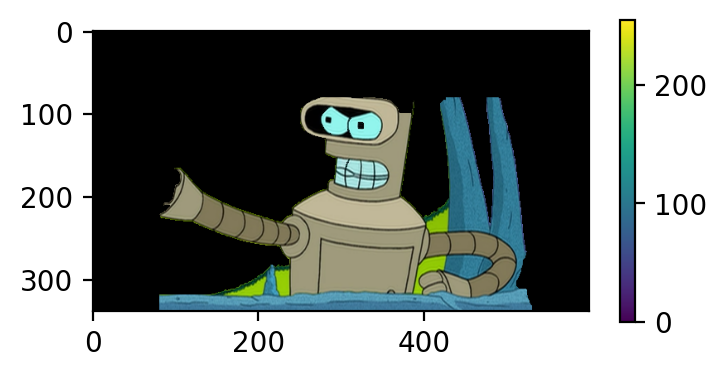

(<matplotlib.image.AxesImage at 0x7ff1439e4750>,
 None)

In [10]:
path = "/content/drive/MyDrive/CVCourse21/pics/bender.png"
imgBGR = cv.imread(path)

mask = np.zeros(imgBGR.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (80,80,450,310)
cv.grabCut(imgBGR,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = imgBGR*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()

**4. Hough Transform**

Hough transform is used in order to detect straight lines throughout the image. The proposed solution of this problem consists of a voting procedure where, for each point in the image corresponding to an edge, a vote is given for every possible line passing through that point. 

By identifying the maximum points in the Hough space, the parametric representation of the most probable lines can be determined. 

image.png


This parametric represention of the line is not optimal, because both parameters for the slope and elevation can take any value in the real numbers set. Instead, we are shifting to the polar representation, where we have to represent the orientation of the line by the *theta* parameter, and the distance to the origin as the *rho* parameter. 

The advantage is that the range of those two parameter is limited (by the image size and by periodicity of the sine function).

image.png


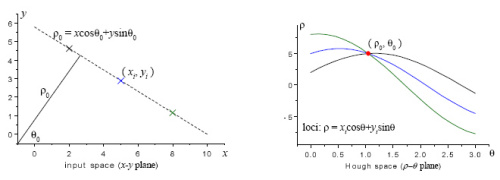

Finally, the solution consists of voting in the *rho, theta* space for any possible line passing through a fixed *x, y* point, that lies on the edge set extracted from the input image. By processing the hough response, extracting local-maximas, we can determine the *rho, theta* parameters describing a line in the image.

Keep in ming that the most probable line is not going to be the most well-defined line in the set of edges. Because of the discretization of the *rho, theta* space, the maximum Hough response will be determined by the bin receiving the most votes by the points lying on the edges. So, a local patch with many points on edges can contribute with more votes than the best well-defined line edge (e. g. *small enough* radius circles with colinear centers).


**References**

* [About Hough Transform](https://dl.acm.org/doi/pdf/10.1145/361237.361242)
* [Canny Edge Detector](https://docs.opencv.org/master/da/d22/tutorial_py_canny.html)

In [11]:
import math 


# img should be a h x w x 1 image after canny edge detector
# the function will return the hough response and samples on the most probable line
def compute_hough_space(img):
  h, w = img.shape
  theta_max = 1.0 * math.pi
  theta_min = 0.0

  rho_min = 0.0
  rho_max = math.hypot(h, w)

  rho_bin = 200
  theta_bin = 300
  hough_space = np.zeros((rho_bin, theta_bin))

  for y in range(h):
    for x in range(w):
      # skip points that are not on the line
      if img[y, x] == 0:
        continue
      else:
        for itheta in range(theta_bin):
          theta = (1.0 * itheta) * (theta_max / theta_bin) # find theta bin
          rho = x * math.cos(theta) + y * math.sin(theta)
          irho = int(rho_bin * rho / rho_max) # find the rho bin
          hough_space[irho, itheta] += 1 # a vote for the given point
  
  # find the most probable line
  r, t = np.unravel_index(np.argmax(hough_space, axis=None), hough_space.shape)
  r_max = r / rho_bin * rho_max 
  t_max = t / theta_bin * theta_max 

  # make sure you test for sin(theta) = 0 when extending the demo
  x = np.arange(w)
  y = 1/math.sin(t_max) * (r_max - x * math.cos(t_max))

  hough_space = np.ceil(255 * (hough_space - hough_space.min())/(hough_space.max() - hough_space.min()))
  return hough_space.astype(np.uint8), x, y


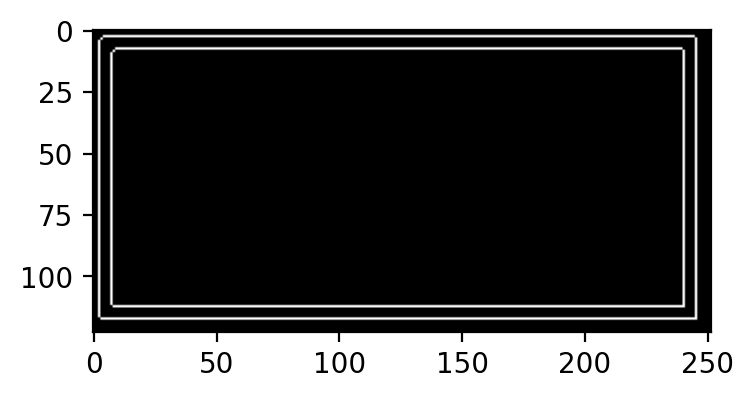

In [12]:
image_rgb = cv.imread("/content/drive/MyDrive/CVCourse21/pics/rectangle.png")
img_gray = cv.cvtColor(image_rgb, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_gray,100,200)
plt.imshow(edges, cmap ='gray')

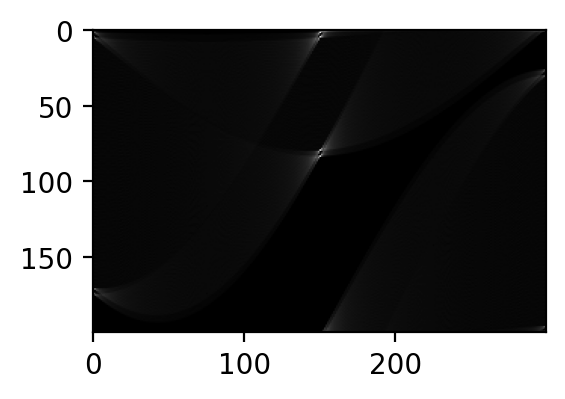

In [13]:
response, x, y = compute_hough_space(edges)
plt.imshow(response, cmap='gray')

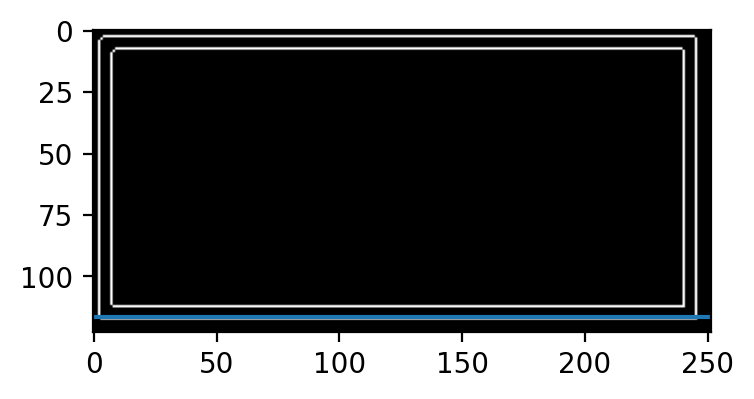

In [14]:
plt.imshow(edges, cmap='gray')
plt.plot(x, y)

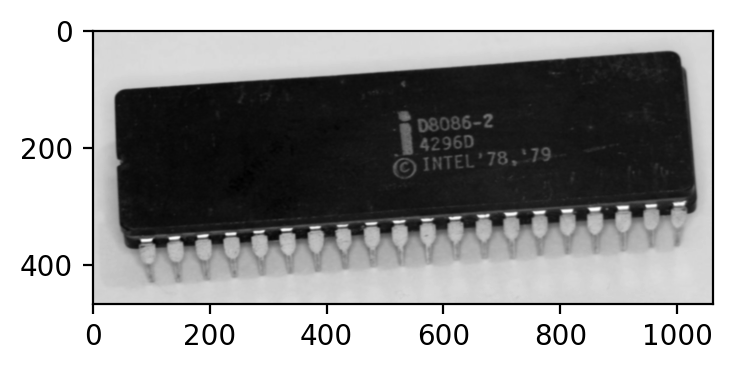

In [15]:
image_rgb = cv.imread("/content/drive/MyDrive/CVCourse21/pics/8086.jpg")
image_rgb = cv.GaussianBlur(image_rgb,(5, 5), 0)
img_gray = cv.cvtColor(image_rgb, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

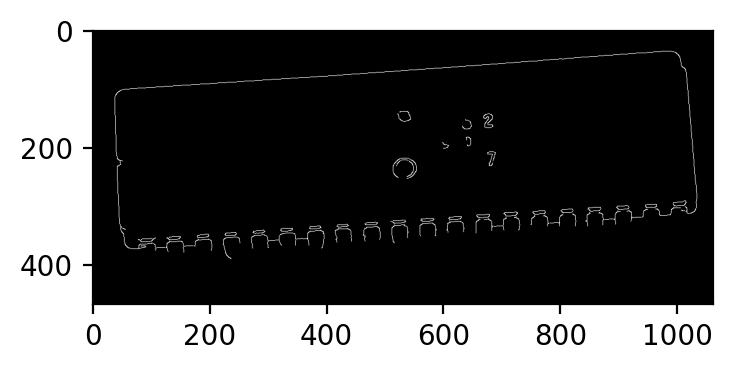

In [16]:
edges = cv.Canny(img_gray, 100, 200)
plt.imshow(edges, cmap='gray')

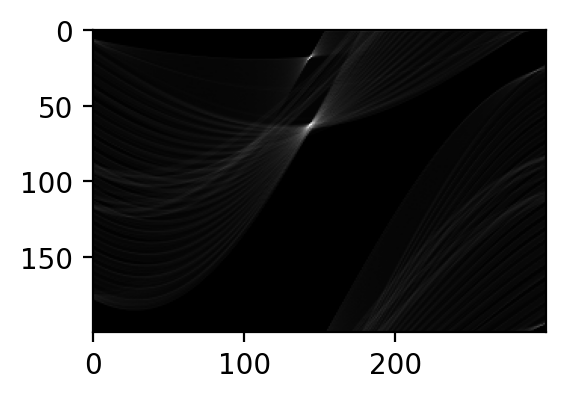

In [17]:
hough_response, x, y = compute_hough_space(edges)
plt.imshow(hough_response, cmap='gray')

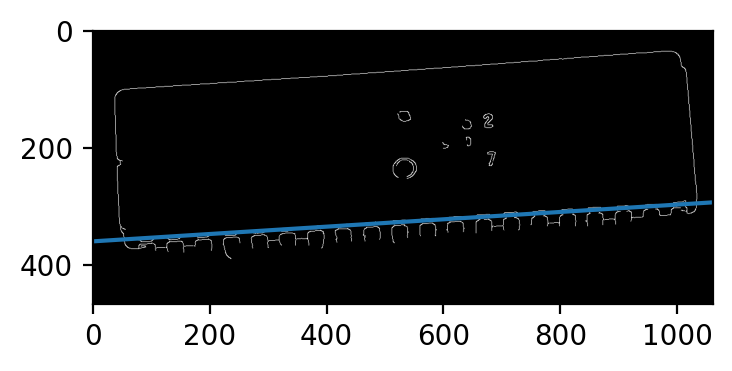

In [18]:
plt.imshow(edges, cmap='gray')
plt.plot(x, y)

**5. Stereo matching**

The figure presented in this section represents the *stereo vision* setup. Two different cameras are used to capture the same object. The center posision of both camera is, evidently known. The line between the camera centers is called *baseline*, and it can be used to determine a 3D model of the observed object.
Each optical center projects in the other image as a point called *the epipole*. The epipole is characteristic to each of the images.

The *epipolar plane* is the plane spanned by a set of three points, the camera centers and the position of the observed point. The intersection between the epipolar plane and both image planes determines the *epipolar lines* in both images.  

Both cameras are characterized by their respective image plane. The lines between the observed point and each camera center are called *lines of sight*. 
As you can see, there exists a transformation between the left image representation and the right image representation. This transformation is called the *fundamental matrix*.

 If the line *P1-P3* is going to be matched, it will appear like a line in the *right image* and a point in the *left image*. So, the transformation is rank deficient.

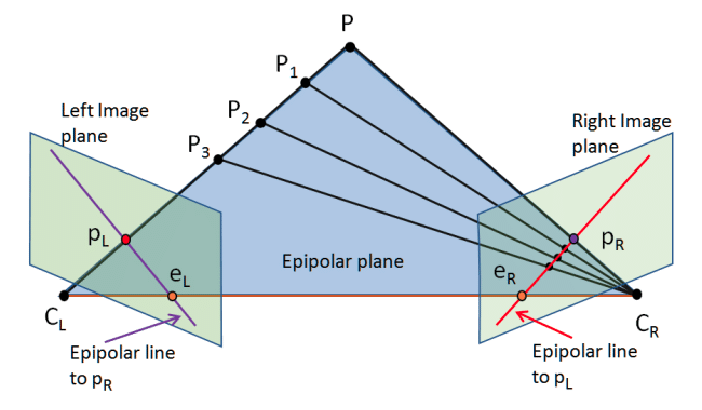


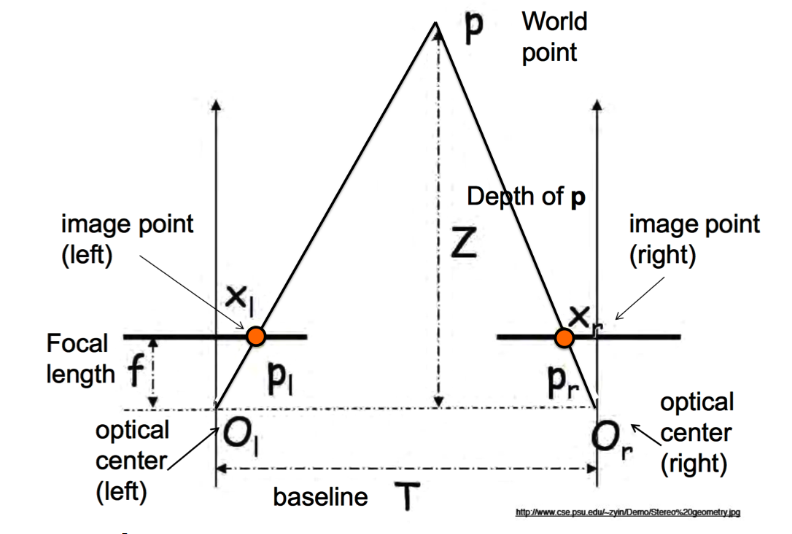

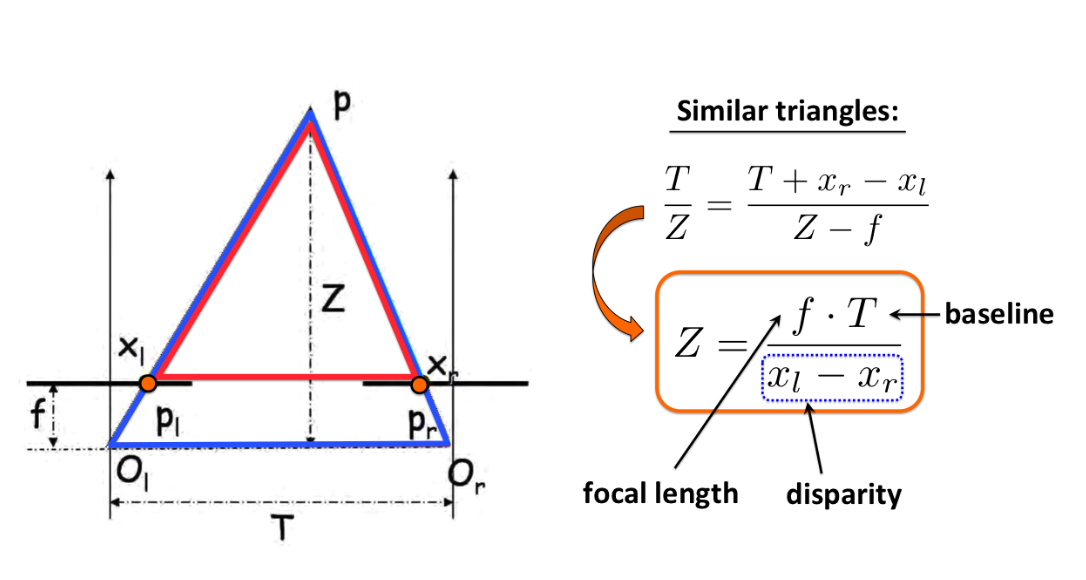


**References**

* [Stereo matching](http://www.cs.toronto.edu/~fidler/slides/2017/CSC420/lecture12_hres.pdf)

* Ingemar J. Cox, Sunita L. Hingorani, Satish B. Rao, Bruce M. Maggs,
A Maximum Likelihood Stereo Algorithm,
Computer Vision and Image Understanding,
Volume 63, Issue 3,
1996,
Pages 542-567,
ISSN 1077-3142,

* [URL for the article with the pseudocode](https://www.sciencedirect.com/science/article/pii/S1077314296900405?via%3Dihub)

* [Data Source](https://home.cvlab.cs.tsukuba.ac.jp/dataset)

In [33]:
left = cv.imread('/content/drive/MyDrive/CVCourse21/pics/imL.png', 0)
right = cv.imread('/content/drive/MyDrive/CVCourse21/pics/imR.png', 0)

(288, 384)


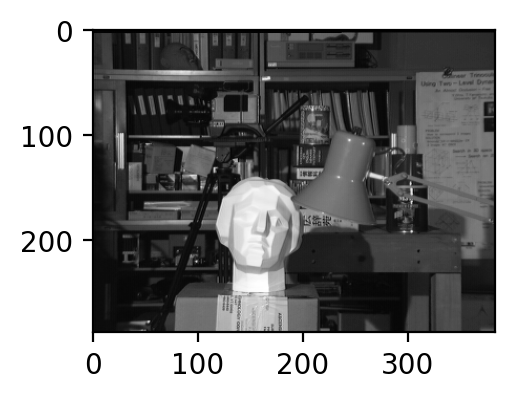

In [34]:
print(left.shape)
plt.imshow(left, cmap='gray')

(288, 384)


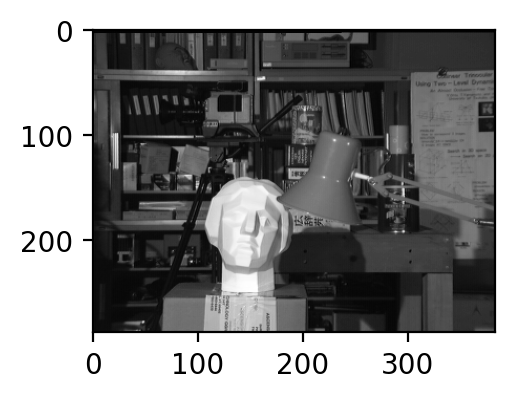

In [35]:
# make sure the images are both same size
h, w = right.shape

print(right.shape)
plt.imshow(right, cmap='gray')

In [26]:
occlusion_cost = 20

disparity_map_left = np.zeros((h, w))
disparity_map_right = np.zeros((h, w))

# populate the cost and direction matrices

for c in range(h - 2): # avoid a 1-pixel border
  cost_matrix = np.zeros((w - 2, w - 2))
  direction_matrix = np.zeros((w - 2, w - 2))

  for i in range(w - 2):
    cost_matrix[i, 0] = i * occlusion_cost
    cost_matrix[0, i] = i * occlusion_cost

  for a in range(w - 2):
    for b in range(w - 2):
      match_cost = np.absolute(left[c, a] - right[c, b])

      min1 = cost_matrix[a - 1, b - 1] + match_cost
      min2 = cost_matrix[a - 1, b] + occlusion_cost
      min3 = cost_matrix[a, b - 1] + occlusion_cost
      cmin = min((min1, min2, min3))
      cost_matrix[a, b] = cmin # 

      if cmin == min1:
        direction_matrix[a, b] = 1
      
      if cmin == min2:
        direction_matrix[a, b] = 2
      
      if cmin == min3:
        direction_matrix[a, b] = 3
  
  p = w - 3
  q = w - 3
  while p > 0 and q > 0:
    if direction_matrix[p, q] == 1:
      disparity_map_left[c, p] = np.absolute(p - q)
      disparity_map_right[c, q] = np.absolute(p - q)
      p -= 1
      q -= 1
    elif direction_matrix[p, q] == 2:
      disparity_map_left[c, p] = 0
      disparity_map_right[c, q] = 0
      p -= 1
    elif direction_matrix[p, q] == 3:
      disparity_map_left[c, p] = 0
      disparity_map_right[c, q] = 0
      q -= 1



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ubyte_scalars


65.0


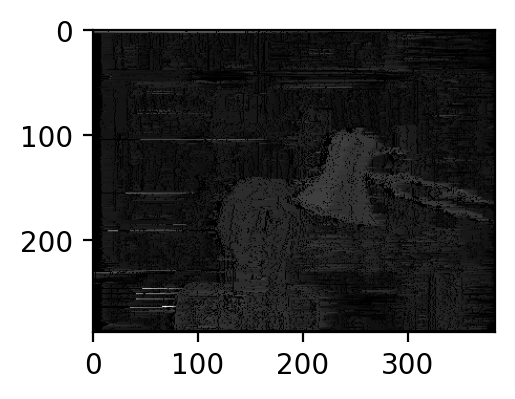

In [31]:
print(disparity_map_left.max())
disparity_map_left = np.ceil((255/disparity_map_left.max()) * disparity_map_left).astype(np.uint8)
plt.imshow(disparity_map_left, cmap='gray')

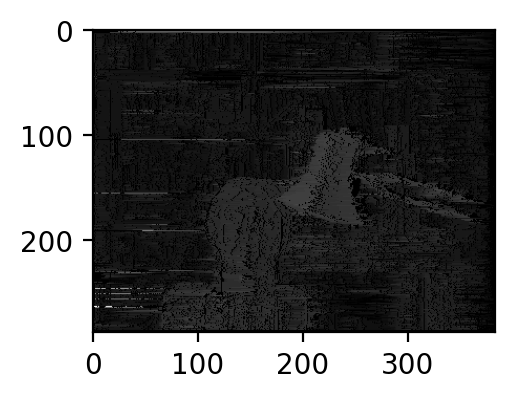

In [32]:
disparity_map_right = np.ceil((255/disparity_map_right.max()) * disparity_map_right).astype(np.uint8)
plt.imshow(disparity_map_right, cmap='gray')